In [1]:
import datasets
import utils

from ela import generator, random

predictions = [utils.TestPredictions('nopoolrefinenet_50_128_lovasz_elu_focal_finetune', mode='val').load_raw()]
samples = utils.get_train_samples()
transforms = transforms = generator.TransformationsGenerator([])
dataset = datasets.StackingDataset(samples, './data/train', transforms, predictions, mode='analyze')

In [2]:
import torch
from tqdm import tqdm
from metrics import mAP

data = {}


for i in tqdm(range(len(dataset))):   
    prediction, target, id = dataset[i]
    
    prediction_tensor = torch.FloatTensor(prediction).unsqueeze(0).unsqueeze(0)
    target_tensor = torch.FloatTensor(target).unsqueeze(0).unsqueeze(0)

    score = mAP(prediction_tensor > 0.5, target_tensor).item()
    
    data[id] = (prediction, target, score)


100%|██████████| 4000/4000 [02:00<00:00, 33.17it/s]


In [14]:
buckets_score = {
    0.25: [],
    0.5: [],
    0.75: [],
    1.00: [],
}

buckets_area = {
    0.001: [],
    0.10: [],
    0.15: [],
    0.20: [],
    0.25: [],
    0.5: [],
    0.75: [],
    1.00: [],
}

for key, (prediction, target, score) in data.items():
    prediction_tensor = torch.FloatTensor(prediction).unsqueeze(0).unsqueeze(0)
    target_tensor = torch.FloatTensor(target).unsqueeze(0).unsqueeze(0)

    for key in buckets_score:
            if score <= key:
                buckets_score[key].append(score)
                break

    for key in buckets_area:
        if target_tensor.sum() / (101*101) <= key:
            buckets_area[key].append(score)
            break

In [15]:
import numpy as np

overall = 0
for key, item in buckets_score.items():
    print(len(item) / 4000, np.mean(np.array(item)))
    overall += len(item) / 4000 * np.mean(np.array(item))
    
print(overall)

0.1005 0.019900497809
0.02725 0.420183490996
0.045 0.655000004172
0.82725 0.979359321163
0.85309999878


In [16]:
overall = 0
for key, item in buckets_area.items():
    print(key, len(item) / 4000, np.mean(np.array(item)))
    overall += len(item) / 4000 * np.mean(np.array(item))
    
print(overall)

0.001 0.40175 0.940696950833
0.1 0.13275 0.496421843697
0.15 0.04275 0.719883036674
0.2 0.03125 0.80319999814
0.25 0.02625 0.88380951853
0.5 0.1325 0.903773582024
0.75 0.114 0.905921051573
1.0 0.11875 0.902526315059
0.85309999878


In [56]:
buckets_score = {
    0.25: [],
    0.5: [],
    0.75: [],
    1.00: [],
}

buckets_area = {
    0.001: [],
    0.10: [],
    0.15: [],
    0.20: [],
    0.25: [],
    0.5: [],
    0.75: [],
    1.00: [],
}

for id, (prediction, target, score) in data.items():
    prediction_tensor = torch.FloatTensor(prediction).unsqueeze(0).unsqueeze(0)
    target_tensor = torch.FloatTensor(target).unsqueeze(0).unsqueeze(0)

    for key in buckets_score:
            if score <= key:
                buckets_score[key].append((id, prediction, target, score))
                break

    for key in buckets_area:
        if target_tensor.sum() / (101*101) <= key:
            buckets_area[key].append((id, prediction, target, score))
            break

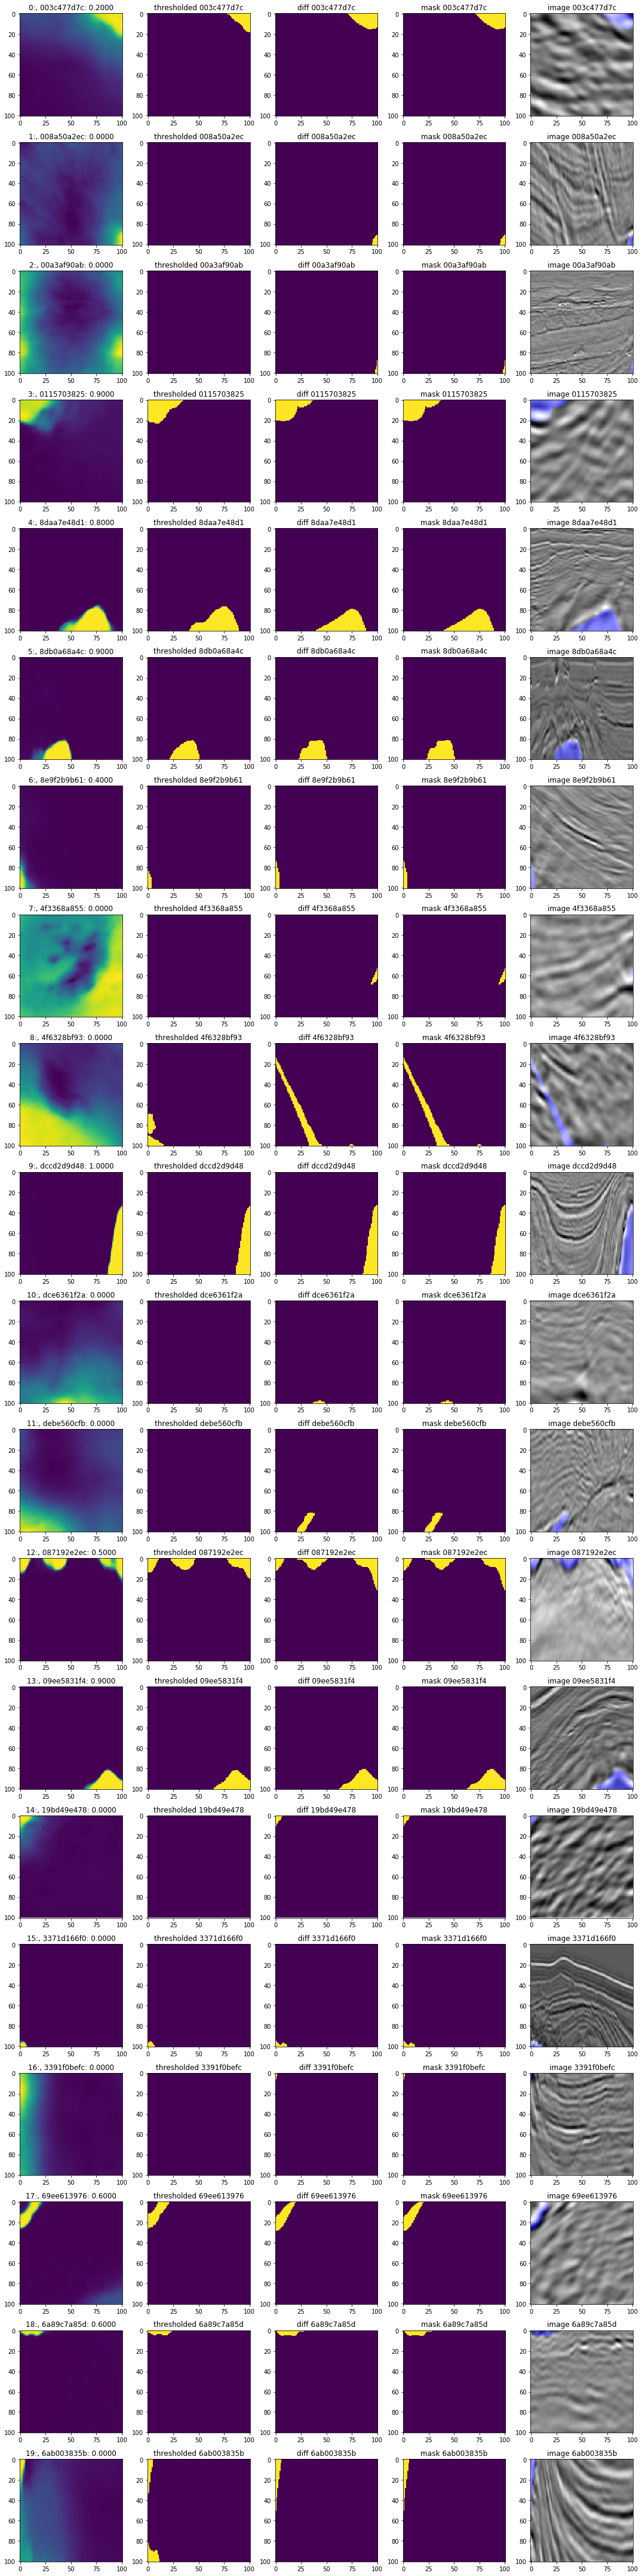

In [81]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import img_as_float
from skimage.io import imread

rows = 20
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
for i, (id, prediction, target, score) in zip(range(rows), buckets_area[0.1]):
    ax[i][0].imshow(prediction)
    ax[i][0].set_title('{}:, {}: {:6.4f}'.format(i, id, score))
    ax[i][1].imshow(prediction > 0.5)
    ax[i][1].set_title('thresholded {}'.format(id))
    ax[i][2].imshow((target - (prediction > 0.5) + ((prediction > 0.5) + target).astype(np.uint)))
    ax[i][2].set_title('diff {}'.format(id))
    ax[i][3].imshow(target)
    ax[i][3].set_title('mask {}'.format(id))
    overlay = np.repeat(np.expand_dims(0.5*target, axis=2), 3, axis=2)
    overlay[:, :, [0, 1]] = 0
    ax[i][4].imshow(np.clip(overlay + img_as_float(imread(join('./data/train', 'images', id) + '.png')), 0, 1))
    ax[i][4].set_title('image {}'.format(id))
    
plt.tight_layout()